# Import libraries

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
import pandas as pd
import numpy as np

import sys 
sys.path.append("diachronic-p2v") 
import os
%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

from utils import prinT

import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
model = p2v.P2V()
d=100
w=10

data_dir:  /mnt/d/projects/diachronic-p2v/data
2024-11-13 16:44:55 -- start loading Mag_venue_info_df
2024-11-13 16:44:55 -- finish.
2024-11-13 16:44:55 -- start loading labeled_journal_info_df
2024-11-13 16:44:55 -- finish.


# Define functions

In [37]:
def default_value():
    return 0


def count_paper_num_for_disc(VID, collapse_into_others=False, percentage=False):
    dict_list = []
    for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
        start_year=model.start_year_list[i]
        end_year=model.end_year_list[i]
        prinT("start searching in %s to %s" %(start_year, end_year))

        model.load_paper_df(full_load=False, start_year=start_year, end_year=end_year)
        model.load_ref_df(full_load=False, start_year=start_year, end_year=end_year)
        VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
        VID_labeled_df = pd.DataFrame(VID_labeled)
        VID_labeled_df.set_index('VID', inplace=True)

        journal_df = model.target_paper_df[model.target_paper_df.VenueID == VID]
        journal_ref_df = pd.merge(journal_df, model.target_ref_df, left_on='PaperID', right_on='PaperID')
        journal_ref_df = pd.merge(journal_ref_df, model.target_paper_df, left_on='PaperReferenceID', right_on='PaperID')
        journal_ref_df.drop(columns=['PaperReferenceID'], inplace=True)
        journal_ref_df = pd.merge(journal_ref_df, VID_labeled_df, left_on='VenueID_y', right_index=True)

        journal_ref_df.drop(journal_ref_df[journal_ref_df['label']=='Multidisciplinary'].index, inplace=True)

        subarea_paper_count = defaultdict(default_value)
        for row in journal_ref_df.groupby(['PaperID_x'])['label'].agg(pd.Series.mode):
            if type(row) == str:
                subarea_paper_count[row] = subarea_paper_count[row] + 1
            if type(row) == np.ndarray:
                subarea_num = len(row)
                for subarea in row:
                    subarea_paper_count[subarea] = subarea_paper_count[subarea] + 1/subarea_num
        dict_list.append(dict(subarea_paper_count))
    count_df = pd.DataFrame(dict_list).T
    count_df.columns = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    count_df['sum']=count_df.sum(axis=1)

    if collapse_into_others:
        count_df.reset_index(inplace=True)
        count_df = count_df.sort_values("sum", ascending=False)
        count_df_up = count_df.iloc[:7]
        count_df_full = pd.concat([count_df_up, 
                                pd.DataFrame([{
                                    'index': 'others',
                                    '1950s': count_df['1950s'].iloc[10:].sum(), 
                                    '1960s': count_df['1960s'].iloc[10:].sum(), 
                                    '1970s': count_df['1970s'].iloc[10:].sum(), 
                                    '1980s': count_df['1980s'].iloc[10:].sum(), 
                                    '1990s': count_df['1990s'].iloc[10:].sum(), 
                                    '2000s': count_df['2000s'].iloc[10:].sum(), 
                                    '2010s': count_df['2010s'].iloc[10:].sum(), 
                                    'sum': count_df['sum'].iloc[7:].sum()}])], 
                                    ignore_index=True)
        count_df_full.set_index('index', inplace=True)
    else:
        count_df_full = count_df
        
    if percentage:
        count_df_full['1950s'] = (count_df_full['1950s']/count_df_full['1950s'].sum()) * 100
        count_df_full['1960s'] = (count_df_full['1960s']/count_df_full['1960s'].sum()) * 100
        count_df_full['1970s'] = (count_df_full['1970s']/count_df_full['1970s'].sum()) * 100
        count_df_full['1980s'] = (count_df_full['1980s']/count_df_full['1980s'].sum()) * 100
        count_df_full['1990s'] = (count_df_full['1990s']/count_df_full['1990s'].sum()) * 100
        count_df_full['2000s'] = (count_df_full['2000s']/count_df_full['2000s'].sum()) * 100
        count_df_full['2010s'] = (count_df_full['2010s']/count_df_full['2010s'].sum()) * 100

    count_df_full.index.rename('decade', inplace=True)
    count_df_full.drop('sum', axis=1, inplace=True)

    return count_df_full.T


def cal_disc_avg_cs(target_VID: int):
    cs_data = []
    for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
        model.load_wv(model.start_year_list[i], model.end_year_list[i], d, w)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)

        VID_labeled = model.load_VID_labeled(model.start_year_list[i], model.end_year_list[i], d, w)
        label_list = VID_labeled['label']
        labeled_VID_list = VID_labeled['VID']
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in labeled_VID_list])

        single_decade_data = {}
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(label_list)) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_subarea_idx_list])
            single_decade_data[subarea] = np.mean((single_subarea_cs))
        cs_data.append(single_decade_data)
    cs_df = pd.DataFrame(cs_data).T
    cs_df.columns = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    cs_df['sum']=cs_df.sum(axis=1)
    cs_df = cs_df.sort_values("sum", ascending=False)
    cs_df.index.rename('decade', inplace=True)
    cs_df.drop('sum', axis=1, inplace=True)

    return cs_df.T

def cal_disc_all_cs(target_VID: int):
    start_year_list = model.start_year_list[-7:]
    end_year_list = model.end_year_list[-7:]

    cs_df = pd.DataFrame(columns=['VID', 'similarity', 'decade', 'discipline'])
    disciplines = model.disc2abbr.keys()

    for start_year, end_year in zip(start_year_list, end_year_list):
        model.load_wv(start_year, end_year, 100, 10)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)
        VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in VID_labeled['VID']])

        for discipline in disciplines:
            single_disc_idx_list = [idx for idx, label in list(enumerate(VID_labeled['label'])) if label == discipline]
            single_disc_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_disc_idx_list])
            for idx, cs_value in enumerate(single_disc_cs[0]):
                new_row = {
                    'VID': VID_labeled['VID'][single_disc_idx_list[idx]],
                    'similarity': cs_value,
                    'decade': f"{start_year}s",
                    'discipline': discipline
                }
                cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)
    cs_df['similarity_ratio'] = cs_df.groupby('decade')['similarity'].transform(lambda x: x/x.mean())
    return cs_df

def cal_jnl_cs(center_vname: str, venue_name_list: list, start_year_list: list, end_year_list: list):
    center_VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==center_vname].index[0]
    jnl_cs_df = pd.DataFrame(columns=venue_name_list)
    
    for i, start_year in enumerate(start_year_list):
        end_year = end_year_list[i]
        wv = model.load_wv(start_year, end_year, d, w)
        
        for venue_name in venue_name_list:
            VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
            try:
                sim = wv.similarity(center_VID, VID)
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = sim
            except KeyError:
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = np.nan
    return jnl_cs_df

Tracking 3 flagships

Nature: 137773608

Science: 3880285

PNAS: 125754415

# Nature

In [55]:
percentage_df = count_paper_num_for_disc(137773608, collapse_into_others=False, percentage=True)

2024-11-13 17:37:14 -- start searching in 1950 to 1959
2024-11-13 17:37:14 -- start loading 'paper_df'...
2024-11-13 17:37:14 -- finish.
2024-11-13 17:37:14 -- start loading 'ref_df'...
2024-11-13 17:37:15 -- finish.
2024-11-13 17:37:15 -- start loading VID_labeled...
2024-11-13 17:37:15 -- finish.
2024-11-13 17:37:15 -- start searching in 1960 to 1969
2024-11-13 17:37:15 -- start loading 'paper_df'...
2024-11-13 17:37:15 -- finish.
2024-11-13 17:37:15 -- start loading 'ref_df'...
2024-11-13 17:37:16 -- finish.
2024-11-13 17:37:16 -- start loading VID_labeled...
2024-11-13 17:37:16 -- finish.
2024-11-13 17:37:17 -- start searching in 1970 to 1979
2024-11-13 17:37:17 -- start loading 'paper_df'...
2024-11-13 17:37:17 -- finish.
2024-11-13 17:37:17 -- start loading 'ref_df'...
2024-11-13 17:37:18 -- finish.
2024-11-13 17:37:18 -- start loading VID_labeled...
2024-11-13 17:37:18 -- finish.
2024-11-13 17:37:20 -- start searching in 1980 to 1989
2024-11-13 17:37:20 -- start loading 'paper_d

In [56]:
percentage_df

decade,Medicine,Physics and Astronomy,Earth and Planetary Sciences,"Biochemistry, Genetics and Molecular Biology",Agricultural and Biological Sciences,Mathematics,Materials Science,Engineering,Immunology and Microbiology,Chemistry,...,Neuroscience,"Pharmacology, Toxicology and Pharmaceutics",Psychology,Dentistry,Chemical Engineering,"Business, Management and Accounting",Energy,Decision Sciences,Environmental Science,Health Professions
1950s,22.862796,9.828984,5.873883,32.420859,14.653268,0.376117,0.824714,1.684689,3.141553,6.096615,...,0.072481,0.383952,0.188058,0.103824,0.095988,0.011754,0.005877,0.011754,NaN,NaN
1960s,23.398229,5.574634,10.762504,26.451105,10.097554,0.175075,1.128731,1.572311,6.431493,8.810161,...,0.475565,1.950238,0.524805,0.280710,0.207902,0.012626,0.082487,NaN,0.066916,0.045452
1970s,13.056629,4.238855,22.716461,29.954610,7.670240,0.138664,0.608147,1.248494,9.424986,3.247123,...,2.768811,1.941398,0.533882,0.055050,0.227471,0.012464,0.081017,0.003116,0.436661,0.015580
1980s,5.799524,12.618017,19.853492,35.232108,7.379831,0.187408,0.411158,0.620473,8.522008,2.064023,...,3.853264,0.664159,0.422302,0.024059,0.100669,0.015195,0.076230,0.007598,0.615408,0.014562
1990s,5.381047,14.678389,15.648163,35.427167,7.776588,0.210015,0.566216,0.441992,4.971998,3.842310,...,6.721435,0.497172,0.676714,0.009883,0.116675,0.032944,0.002745,0.012354,0.857904,0.018531
2000s,8.608415,16.322623,12.837377,30.155082,10.739563,0.390164,1.583825,0.334973,5.002732,3.102404,...,5.831148,0.418579,0.657923,0.006557,0.110383,0.049180,0.083060,0.026230,1.536066,0.078689
2010s,14.258200,13.793272,9.016516,31.126196,7.609172,0.165250,2.875800,0.483279,4.434497,4.516721,...,4.504427,0.517754,0.606660,0.021380,0.069040,0.164092,0.379675,0.010690,2.654159,0.013363


In [57]:
count_df = count_paper_num_for_disc(137773608, collapse_into_others=False, percentage=False)

2024-11-13 17:39:08 -- start searching in 1950 to 1959
2024-11-13 17:39:08 -- start loading 'paper_df'...
2024-11-13 17:39:08 -- finish.
2024-11-13 17:39:08 -- start loading 'ref_df'...
2024-11-13 17:39:08 -- finish.
2024-11-13 17:39:08 -- start loading VID_labeled...
2024-11-13 17:39:08 -- finish.
2024-11-13 17:39:09 -- start searching in 1960 to 1969
2024-11-13 17:39:09 -- start loading 'paper_df'...
2024-11-13 17:39:09 -- finish.
2024-11-13 17:39:09 -- start loading 'ref_df'...
2024-11-13 17:39:09 -- finish.
2024-11-13 17:39:09 -- start loading VID_labeled...
2024-11-13 17:39:09 -- finish.
2024-11-13 17:39:11 -- start searching in 1970 to 1979
2024-11-13 17:39:11 -- start loading 'paper_df'...
2024-11-13 17:39:11 -- finish.
2024-11-13 17:39:11 -- start loading 'ref_df'...
2024-11-13 17:39:12 -- finish.
2024-11-13 17:39:12 -- start loading VID_labeled...
2024-11-13 17:39:12 -- finish.
2024-11-13 17:39:14 -- start searching in 1980 to 1989
2024-11-13 17:39:14 -- start loading 'paper_d

In [58]:
count_df

decade,Medicine,Physics and Astronomy,Earth and Planetary Sciences,"Biochemistry, Genetics and Molecular Biology",Agricultural and Biological Sciences,Mathematics,Materials Science,Engineering,Immunology and Microbiology,Chemistry,...,Neuroscience,"Pharmacology, Toxicology and Pharmaceutics",Psychology,Dentistry,Chemical Engineering,"Business, Management and Accounting",Energy,Decision Sciences,Environmental Science,Health Professions
1950s,1945.166667,836.250000,499.750000,2758.366667,1246.700000,32.000000,70.166667,143.333333,267.283333,518.700000,...,6.166667,32.666667,16.000000,8.833333,8.166667,1.0,0.500000,1.0,NaN,NaN
1960s,4633.083333,1103.833333,2131.083333,5237.583333,1999.416667,34.666667,223.500000,311.333333,1273.500000,1744.500000,...,94.166667,386.166667,103.916667,55.583333,41.166667,2.5,16.333333,NaN,13.250000,9.000000
1970s,2095.066667,680.166667,3645.083333,4806.516667,1230.766667,22.250000,97.583333,200.333333,1512.333333,521.033333,...,444.283333,311.516667,85.666667,8.833333,36.500000,2.0,13.000000,0.5,70.066667,2.500000
1980s,763.333333,1660.783333,2613.116667,4637.250000,971.333333,24.666667,54.116667,81.666667,1121.666667,271.666667,...,507.166667,87.416667,55.583333,3.166667,13.250000,2.0,10.033333,1.0,81.000000,1.916667
1990s,653.366667,1782.250000,1900.000000,4301.566667,944.233333,25.500000,68.750000,53.666667,603.700000,466.533333,...,816.116667,60.366667,82.166667,1.200000,14.166667,4.0,0.333333,1.5,104.166667,2.250000
2000s,1312.783333,2489.200000,1957.700000,4598.650000,1637.783333,59.500000,241.533333,51.083333,762.916667,473.116667,...,889.250000,63.833333,100.333333,1.000000,16.833333,7.5,12.666667,4.0,234.250000,12.000000
2010s,2667.566667,2580.583333,1686.900000,5823.400000,1423.600000,30.916667,538.033333,90.416667,829.650000,845.033333,...,842.733333,96.866667,113.500000,4.000000,12.916667,30.7,71.033333,2.0,496.566667,2.500000


In [38]:
all_cs_df = cal_disc_all_cs(137773608)

2024-11-13 17:24:36 -- start loading word vectors...
2024-11-13 17:24:36 -- word vectors loaded, and its shape is: (1645, 100)
2024-11-13 17:24:36 -- start loading VID_labeled...
2024-11-13 17:24:36 -- finish.


/tmp/ipykernel_158071/1096938099.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)


2024-11-13 17:24:37 -- start loading word vectors...
2024-11-13 17:24:37 -- word vectors loaded, and its shape is: (3116, 100)
2024-11-13 17:24:37 -- start loading VID_labeled...
2024-11-13 17:24:37 -- finish.
2024-11-13 17:24:37 -- start loading word vectors...
2024-11-13 17:24:37 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-13 17:24:37 -- start loading VID_labeled...
2024-11-13 17:24:37 -- finish.
2024-11-13 17:24:38 -- start loading word vectors...
2024-11-13 17:24:38 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-13 17:24:38 -- start loading VID_labeled...
2024-11-13 17:24:38 -- finish.
2024-11-13 17:24:41 -- start loading word vectors...
2024-11-13 17:24:41 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-13 17:24:41 -- start loading VID_labeled...
2024-11-13 17:24:41 -- finish.
2024-11-13 17:24:45 -- start loading word vectors...
2024-11-13 17:24:46 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-13 17:24:46 -- start lo

In [39]:
all_cs_df

,VID,similarity,decade,discipline,similarity_ratio
0,140251998,0.467104,1950s,"Biochemistry, Genetics and Molecular Biology",2.051993
1,111155417,0.465078,1950s,"Biochemistry, Genetics and Molecular Biology",2.043091
2,153476765,0.496364,1950s,"Biochemistry, Genetics and Molecular Biology",2.180532
3,44425019,0.508835,1950s,"Biochemistry, Genetics and Molecular Biology",2.235315
4,67514239,0.321755,1950s,"Biochemistry, Genetics and Molecular Biology",1.413472
...,...,...,...,...,...
62473,199547652,0.116194,2010s,Multidisciplinary,0.647700
62474,42616313,0.265315,2010s,Multidisciplinary,1.478938
62475,2764886163,0.052513,2010s,Multidisciplinary,0.292723
62476,20993697,0.117977,2010s,Multidisciplinary,0.657635


In [27]:
for decade in all_cs_df.decade.unique():
    print(all_cs_df[all_cs_df.decade==decade].similarity.mean())

0.22763449
0.18605721
0.18140319
0.16754654
0.17600095
0.15894404
0.17939553


In [18]:
all_cs_df[(all_cs_df.discipline=='Earth and Planetary Sciences') &
          (all_cs_df.decade=='1970s')
          ].similarity.mean()

0.33860132

In [10]:
cs_df = cal_disc_avg_cs(137773608)

2024-11-13 16:47:45 -- start loading word vectors...
2024-11-13 16:47:45 -- word vectors loaded, and its shape is: (1645, 100)
2024-11-13 16:47:45 -- start loading VID_labeled...
2024-11-13 16:47:45 -- finish.
2024-11-13 16:47:45 -- start loading word vectors...
2024-11-13 16:47:45 -- word vectors loaded, and its shape is: (3116, 100)
2024-11-13 16:47:45 -- start loading VID_labeled...
2024-11-13 16:47:45 -- finish.
2024-11-13 16:47:45 -- start loading word vectors...
2024-11-13 16:47:45 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-13 16:47:45 -- start loading VID_labeled...
2024-11-13 16:47:45 -- finish.
2024-11-13 16:47:45 -- start loading word vectors...
2024-11-13 16:47:45 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-13 16:47:45 -- start loading VID_labeled...
2024-11-13 16:47:45 -- finish.
2024-11-13 16:47:45 -- start loading word vectors...
2024-11-13 16:47:45 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-13 16:47:45 -- start loa

In [11]:
cs_df

decade,Multidisciplinary,"Biochemistry, Genetics and Molecular Biology",Earth and Planetary Sciences,Immunology and Microbiology,Neuroscience,Agricultural and Biological Sciences,Physics and Astronomy,Chemistry,"Pharmacology, Toxicology and Pharmaceutics",Veterinary,...,Computer Science,Psychology,Mathematics,Social Sciences,Health Professions,"Economics, Econometrics and Finance",Arts and Humanities,Nursing,Decision Sciences,"Business, Management and Accounting"
1950s,0.438359,0.360366,0.334687,0.325002,0.297717,0.352262,0.357147,0.347693,0.277557,0.358920,...,0.216640,0.147159,0.158969,0.102109,0.123420,0.092645,0.059731,0.170855,0.189596,0.024680
1960s,0.404714,0.317183,0.325942,0.316138,0.235040,0.288805,0.272092,0.271480,0.256571,0.320339,...,0.162385,0.144706,0.087109,0.055612,0.089292,0.007962,0.010663,0.103876,0.038733,-0.003603
1970s,0.390110,0.335735,0.338601,0.330816,0.328863,0.261508,0.227404,0.236840,0.272009,0.218038,...,0.101440,0.144676,0.120197,0.092909,0.105670,0.083817,0.078893,0.067863,0.079904,0.032330
1980s,0.374284,0.310549,0.327134,0.302565,0.332571,0.230266,0.239946,0.211581,0.208938,0.169005,...,0.149946,0.125681,0.127551,0.097777,0.078402,0.110589,0.093987,0.063897,0.091906,0.105692
1990s,0.318050,0.328582,0.312088,0.307091,0.334301,0.257665,0.251203,0.262142,0.212125,0.170174,...,0.109586,0.151240,0.127540,0.117283,0.133990,0.110596,0.129184,0.096003,0.073662,0.056828
2000s,0.231741,0.290635,0.259214,0.248598,0.259689,0.236910,0.262585,0.219985,0.158467,0.119818,...,0.143975,0.133523,0.157034,0.136896,0.096577,0.142053,0.130065,0.063930,0.111164,0.110715
2010s,0.238792,0.279424,0.240136,0.261621,0.216604,0.219596,0.227179,0.215618,0.158379,0.161799,...,0.137895,0.155212,0.164211,0.177166,0.110966,0.176846,0.203109,0.109397,0.090119,0.151931


In [43]:
start_year_list = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
end_year_list = [1959, 1969, 1979, 1989, 1999, 2009, 2021]
venue_name_list = [
    # 'Journal of Molecular Biology',

    # 'Scottish Journal of Geology',
    'Geological Journal',

    # 'JAMA',
    # 'The New England Journal of Medicine',

    # 'Physical Review Letters',
    'Reports on Progress in Physics', 
]
jnl_cs_df = cal_jnl_cs('Nature', venue_name_list, start_year_list=start_year_list, end_year_list=end_year_list)
jnl_cs_df

2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (1645, 100)
2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (3116, 100)
2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 11:11:03 -- start loading word vectors...
2024-11-08 11:11:03 -- word vectors loaded, and its shape is: (37594, 100)


,Geological Journal,Reports on Progress in Physics
1950s,NaN,NaN
1960s,NaN,0.164667
1970s,0.288486,0.112823
1980s,0.254231,0.137076
1990s,0.258641,0.14299
2000s,0.175973,0.501192
2010s,0.227368,0.290924


Pearson correlation coefficient: 0.665
P-value: 1.218e-24


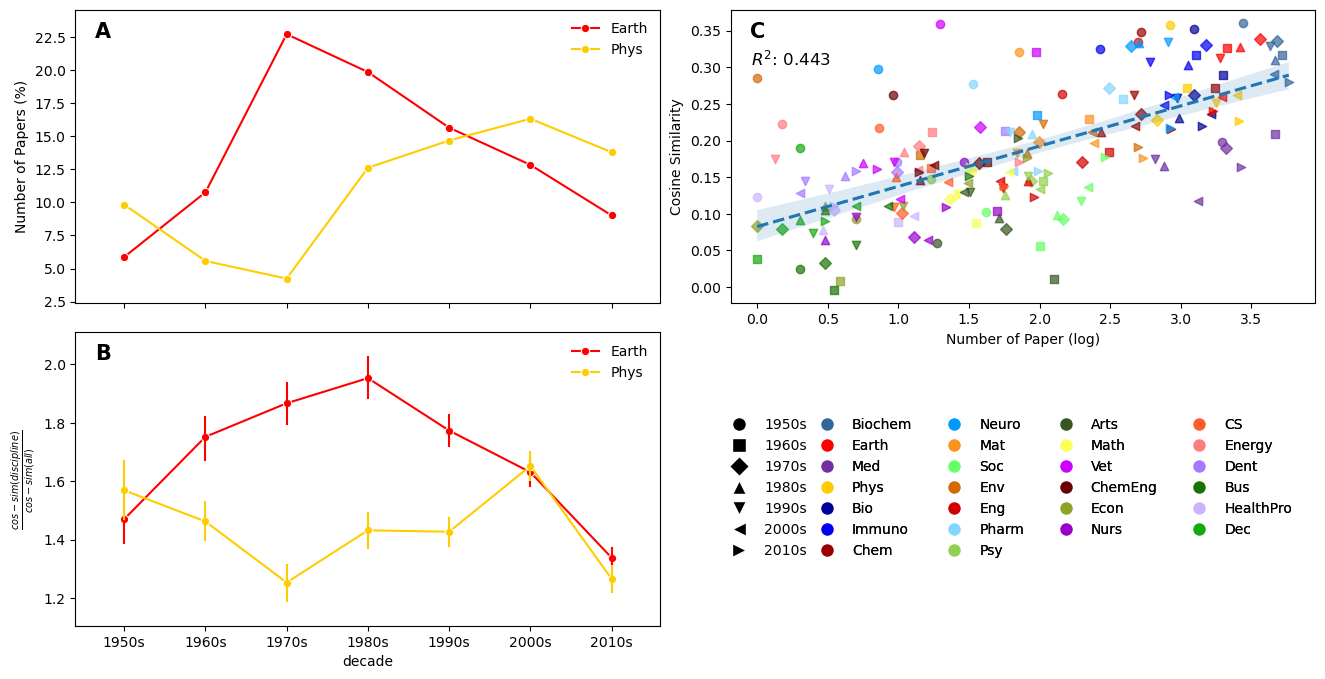

In [62]:
from scipy.stats import pearsonr

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0)

decades = count_df.index.tolist() # get decades

pannel_labels = list("ABC")
fig = plt.figure(figsize=(16, 8))
##########################################
ax_1 = fig.add_subplot(2,2,1)
plt.margins(x=0.1, y=0.1)
sns.lineplot(percentage_df[['Earth and Planetary Sciences', 'Physics and Astronomy']], 
             ax=ax_1, palette=model.discipline2color, marker='o', dashes=False)
# ax_1.set_yscale('log')
handles, labels = ax_1.get_legend_handles_labels()
ax_1.legend(handles, [model.disc2abbr[label] for label in labels], frameon=False)
ax_1.set_ylabel('Number of Papers (%)')
ax_1.tick_params(labelbottom=False) # hide x-axis labels
# Plot pannel labels
ax_1.text(0.06, 0.96, pannel_labels[0], transform=ax_1.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')
##########################################
ax_2 = fig.add_subplot(2,2,3, sharex=ax_1)
plt.margins(x=0.1, y=0.1)
melted_all_cs_df = pd.melt(all_cs_df[all_cs_df.discipline.isin(['Earth and Planetary Sciences', 'Physics and Astronomy'])], 
                           id_vars=['VID', 'discipline', 'decade'], value_vars='similarity_ratio')
sns.lineplot(data=melted_all_cs_df, x='decade', y='value', hue='discipline', palette=model.discipline2color, 
             err_style='bars', marker='o', dashes=False, ax=ax_2)
ax_2.set_ylabel(r'$\frac{cos-sim(discipline)}{cos-sim(all)}$')
handles, labels = ax_2.get_legend_handles_labels()
ax_2.legend(handles, [model.disc2abbr[label] for label in labels], frameon=False)
ax_2.text(0.06, 0.96, pannel_labels[1], transform=ax_2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right') # Plot pannel labels
##########################################
ax = fig.add_subplot(2,2,2)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, color=model.discipline2color[discipline], label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

ss_res = np.sum((combined_y_vals - np.polyval(np.polyfit(combined_x_vals, combined_y_vals, 1), combined_x_vals)) ** 2)
ss_tot = np.sum((combined_y_vals - np.mean(combined_y_vals)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
ax.text(0.035, 0.87, f"$R^2$: {r_squared:.3f}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',)

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
print(f"Pearson correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3e}")

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model.disc2abbr[disc],
                                 markerfacecolor=model.discipline2color[disc], markersize=10)
                      for disc in disciplines]

legend_ax = fig.add_subplot(2,2,4)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(-0.03, 0.75), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                              loc="upper left", bbox_to_anchor=(0.12, 0.75), ncol=4, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_ylabel('Cosine Similarity')
ax.text(0.06, 0.96, pannel_labels[2], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

plt.subplots_adjust(wspace=0.12, hspace=0.1)
plt.show()

In [64]:
fig.savefig('diachronic-p2v/figures/validation/Nature_correlation.pdf', 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

## Old layout

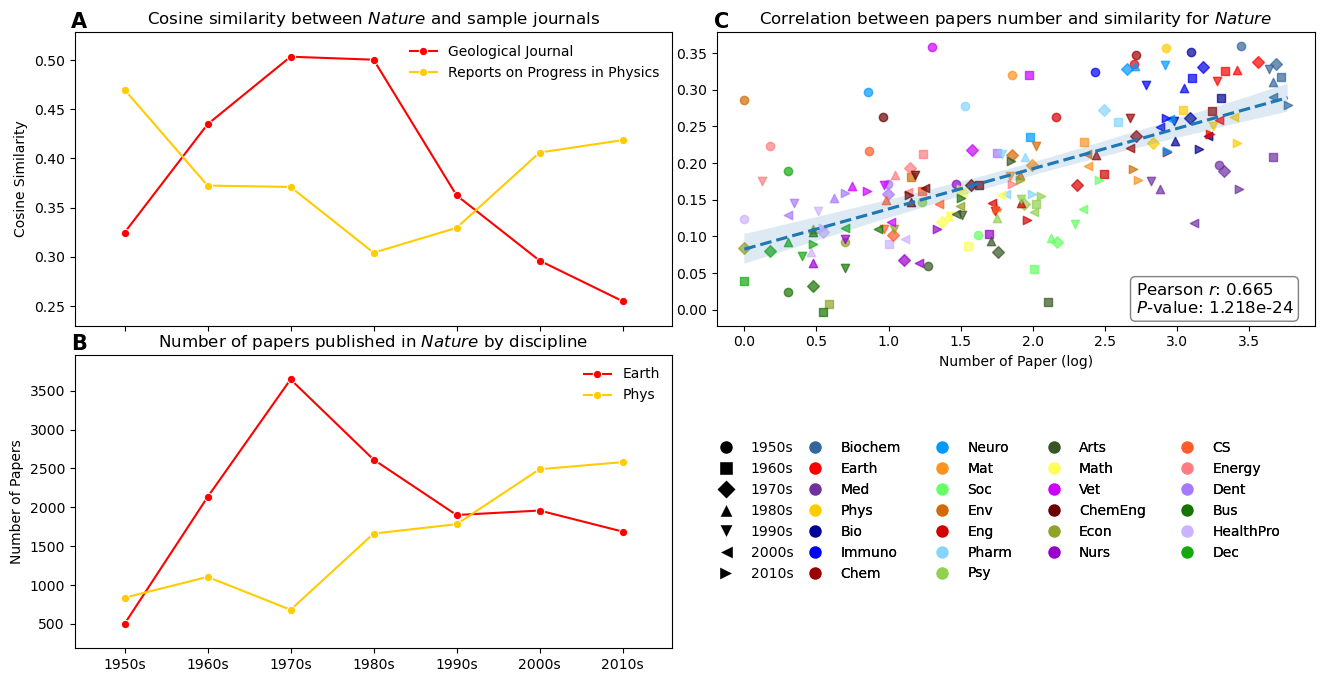

In [ ]:
from scipy.stats import pearsonr

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

decades = count_df.index.tolist() # get decades

pannel_labels = list("ABC")
center_venue = 'Nature'
fig = plt.figure(figsize=(16, 8))
##########################################
ax_2 = fig.add_subplot(2,2,3)
sns.lineplot(count_df[[# 'Biochemistry, Genetics and Molecular Biology', 
                       # 'Agricultural and Biological Sciences', 
                          'Earth and Planetary Sciences', 
                          # 'Medicine',
                          'Physics and Astronomy']], 
             ax=ax_2, palette=model.discipline2color, marker='o', dashes=False)
plt.margins(x=0.1, y=0.1)
ax_2.set_title(r'Number of papers published in $\it{%s}$ by discipline' % center_venue)
ax_2.set_ylabel('Number of Papers')
handles, labels = ax_2.get_legend_handles_labels()
ax_2.legend(handles, [model.disc2abbr[label] for label in labels], frameon=False)
# Plot pannel labels
ax_2.text(0.02, 1.07, pannel_labels[1], transform=ax_2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')
##########################################
jnl_color_dict = {
    # 'J. Mol. Biol.': '#336699',

    # 'PRL': '#FFCC00',
    'Reports on Progress in Physics': '#FFCC00',

    # 'Scott. J. Geol.': '#FE0000',
    'Geological Journal': '#FE0000',

    # 'JAMA': '#7030A0',
    # 'The New England Journal of Medicine': '#7030A0',
}
jnl_abbr_dict = {
    'Journal of Molecular Biology': 'J. Mol. Biol.',
    'Scottish Journal of Geology': 'Scott. J. Geol.',
    'The Lancet': 'Lancet',
    'Physical Review Letters': 'PRL',
}
ax_2 = fig.add_subplot(2,2,1, sharex=ax_2)
jnl_cs_df.rename(columns=jnl_abbr_dict, inplace=True)
plt.margins(x=0.1, y=0.1)
sns.lineplot(jnl_cs_df, ax=ax_2, palette=jnl_color_dict, marker='o',dashes=False)
ax_2.set_title(r'Cosine similarity between $\it{%s}$ and sample journals' % center_venue)
ax_2.set_ylabel('Cosine Similarity')
ax_2.tick_params(labelbottom=False) # hide x-axis labels
ax_2.legend(frameon=False)
ax_2.text(0.02, 1.07, pannel_labels[0], transform=ax_2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right') # Plot pannel labels
##########################################
ax = fig.add_subplot(2,2,2)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, color=model.discipline2color[discipline], label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
ax.text(0.70, 0.15, f"Pearson $r$: {correlation_coef:.3f}\n$P$-value: {p_value:.3e}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',
          bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white"))

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model.disc2abbr[disc],
                                 markerfacecolor=model.discipline2color[disc], markersize=10)
                      for disc in disciplines]

legend_ax = fig.add_subplot(2,2,4)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(-0.03, 0.75), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                              loc="upper left", bbox_to_anchor=(0.12, 0.75), ncol=4, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_title(f'Correlation between papers number and similarity for $\it{{{center_venue}}}$')
ax.text(0.02, 1.07, pannel_labels[2], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

plt.subplots_adjust(wspace=0.075, hspace=0.1)
plt.show()

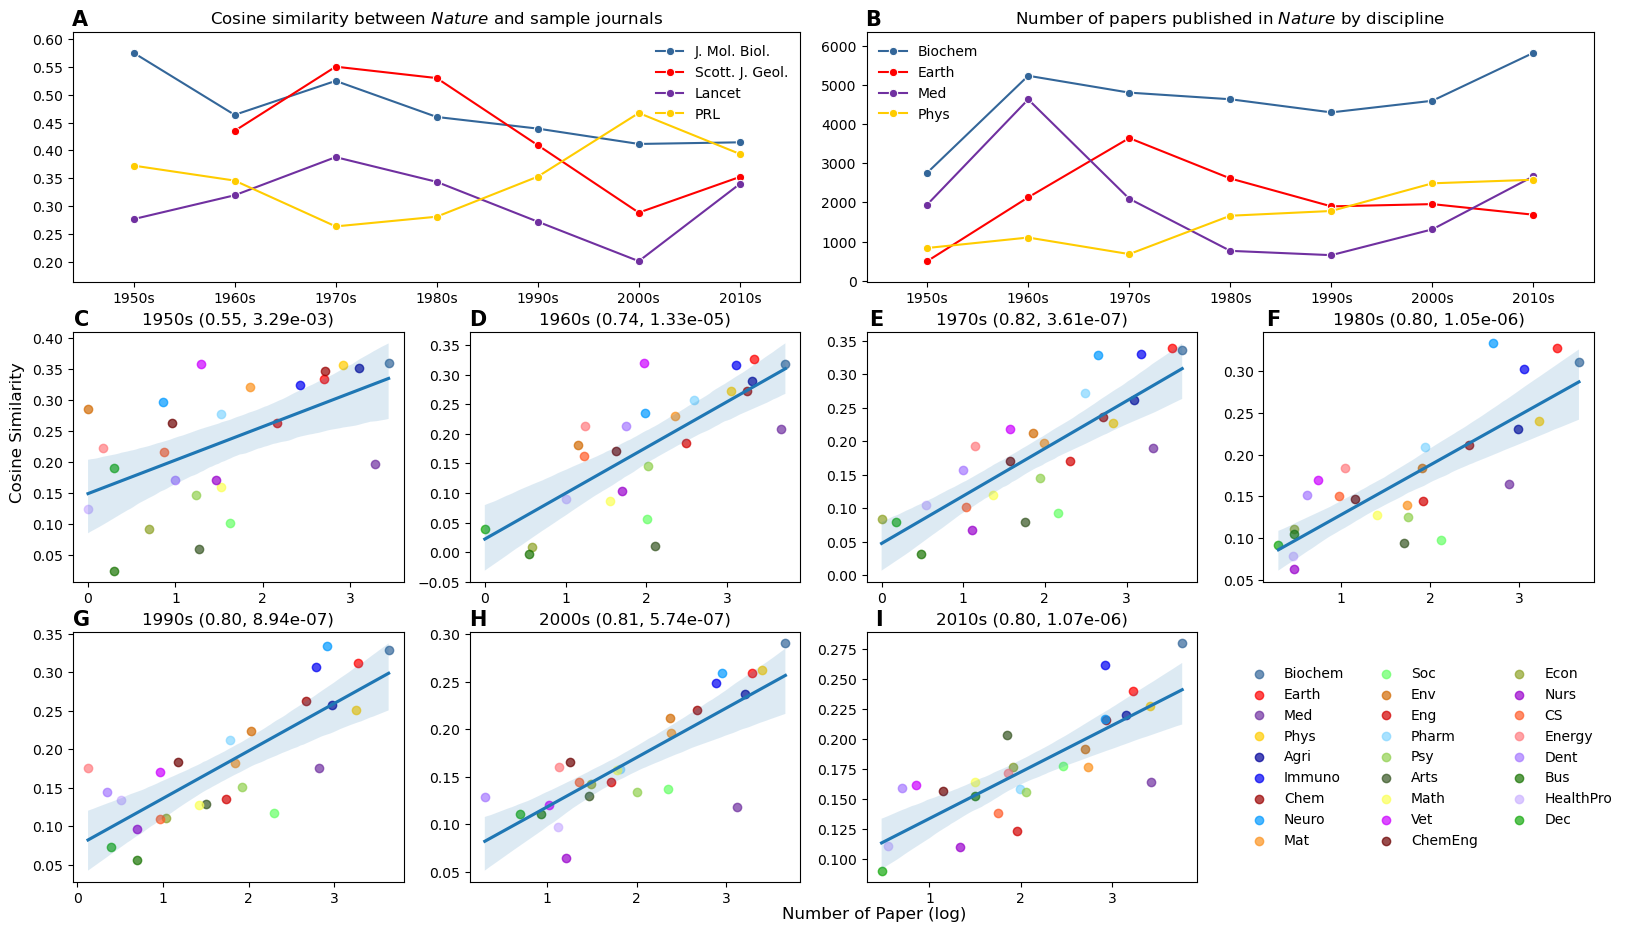

In [ ]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# re-order the columns
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

decades = count_df.index.tolist() # get decades

# 创建一个 3x4 的 GridSpec 布局（3 行 4 列）
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFGHI")
center_venue = 'Nature'

# 添加大图，跨越整个图形的前两列（3x4 的 GridSpec 布局中的第一个大区域）
jnl_color_dict = {
    'J. Mol. Biol.': '#336699',
    'PRL': '#FFCC00',
    'Scott. J. Geol.': '#FE0000',
    'Lancet': '#7030A0'
}
jnl_abbr_dict = {
    'Journal of Molecular Biology': 'J. Mol. Biol.',
    'Scottish Journal of Geology': 'Scott. J. Geol.',
    'The Lancet': 'Lancet',
    'Physical Review Letters': 'PRL',
}
ax_big_left = fig.add_subplot(gs[0, 0:2])
jnl_cs_df.rename(columns=jnl_abbr_dict, inplace=True)
plt.margins(x=0.1, y=0.1)
sns.lineplot(jnl_cs_df, ax=ax_big_left, palette=jnl_color_dict, marker='o',dashes=False)
ax_big_left.set_title(r'Cosine similarity between $\it{%s}$ and sample journals' % center_venue)
ax_big_left.legend(frameon=False)
# Plot pannel labels
ax_big_left.text(0.02, 1.09, pannel_labels[0], transform=ax_big_left.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 添加大图，跨越整个图形的前两列（3x4 的 GridSpec 布局中的第二个大区域）
ax_big_right = fig.add_subplot(gs[0, 2:4])
sns.lineplot(count_df[['Biochemistry, Genetics and Molecular Biology', 'Earth and Planetary Sciences', 'Medicine','Physics and Astronomy']], 
             ax=ax_big_right, palette=model.discipline2color, marker='o', dashes=False)
plt.margins(x=0.1, y=0.1)
ax_big_right.set_title(r'Number of papers published in $\it{%s}$ by discipline' % center_venue)
handles, labels = ax_big_right.get_legend_handles_labels()
ax_big_right.legend(handles, [model.disc2abbr[label] for label in labels], frameon=False)
# Plot pannel labels
ax_big_right.text(0.02, 1.09, pannel_labels[1], transform=ax_big_right.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[1 + i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, color=model.discipline2color[discipline], alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i+2], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-1])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, [model.disc2abbr[label] for label in labels], loc='center', ncol=3, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.05, wspace=0.1, hspace=0.2)

plt.show()

In [151]:
fig.savefig('Nature_correlation.pdf', 
            facecolor='white', 
            transparent=False)

## Archive

In [155]:
start_year_list = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
end_year_list = [1959, 1969, 1979, 1989, 1999, 2009, 2021]
venue_name_list = [
    'Journal of the American Chemical Society',
    'Physical Review Letters',
    'Scottish Journal of Geology',
    'Journal of Molecular Biology',
    'Science',
]
jnl_cs_df = cal_jnl_cs('Nature', venue_name_list)
jnl_cs_df

2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (1645, 100)
2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (3116, 100)
2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (5686, 100)
2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (9337, 100)
2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (15019, 100)
2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (27460, 100)
2024-08-14 15:35:42 -- start loading word vectors...
2024-08-14 15:35:42 -- word vectors loaded, and its shape is: (37594, 100)


,Journal of the American Chemical Society,Physical Review Letters,Scottish Journal of Geology,Journal of Molecular Biology,Science
1950s,0.465078,0.37296,NaN,0.574509,0.47727
1960s,0.38859,0.346212,0.435059,0.46367,0.649296
1970s,0.344149,0.264323,0.549757,0.524373,0.716935
1980s,0.333737,0.281669,0.529402,0.459919,0.76703
1990s,0.440778,0.353227,0.409503,0.439107,0.880986
2000s,0.431482,0.466972,0.288958,0.411674,0.856079
2010s,0.39197,0.393844,0.352721,0.414602,0.823515


In [ ]:
color_dict = {'Chemical Engineering': '#6C0000',
              'Chemistry': '#9A0000',
              'Computer Science': '#FF5C29',
              'Earth and Planetary Sciences': '#FE0000',                   
              'Energy': '#FF7C80',
              'Engineering': '#D20000',
              'Environmental Science': '#D26B04',
              'Materials Science': '#FC9320',
              'Mathematics': '#FBFF57',
              'Physics and Astronomy': '#FFCC00',
              
              'Medicine' :'#7030A0',
              'Nursing': '#9900CC',
              'Veterinary': '#CC00FF',
              'Dentistry': '#A679FF',
              'Health Professions': '#CCB3FF',
              
              'Arts and Humanities': '#375623',
              'Business, Management and Accounting': '#187402',
              'Decision Sciences': '#16A90F',
              'Economics, Econometrics and Finance': '#8FA329',
              'Psychology': '#92D050',
              'Social Sciences': '#66FF66',
              
              'Agricultural and Biological Sciences': '#000099',
              'Biochemistry, Genetics and Molecular Biology': '#336699',
              'Immunology and Microbiology': '#0000F2',
              'Neuroscience': '#0099FF',
              'Pharmacology, Toxicology and Pharmaceutics': '#85D6FF',
              
              'others': '#b3b3b3'}

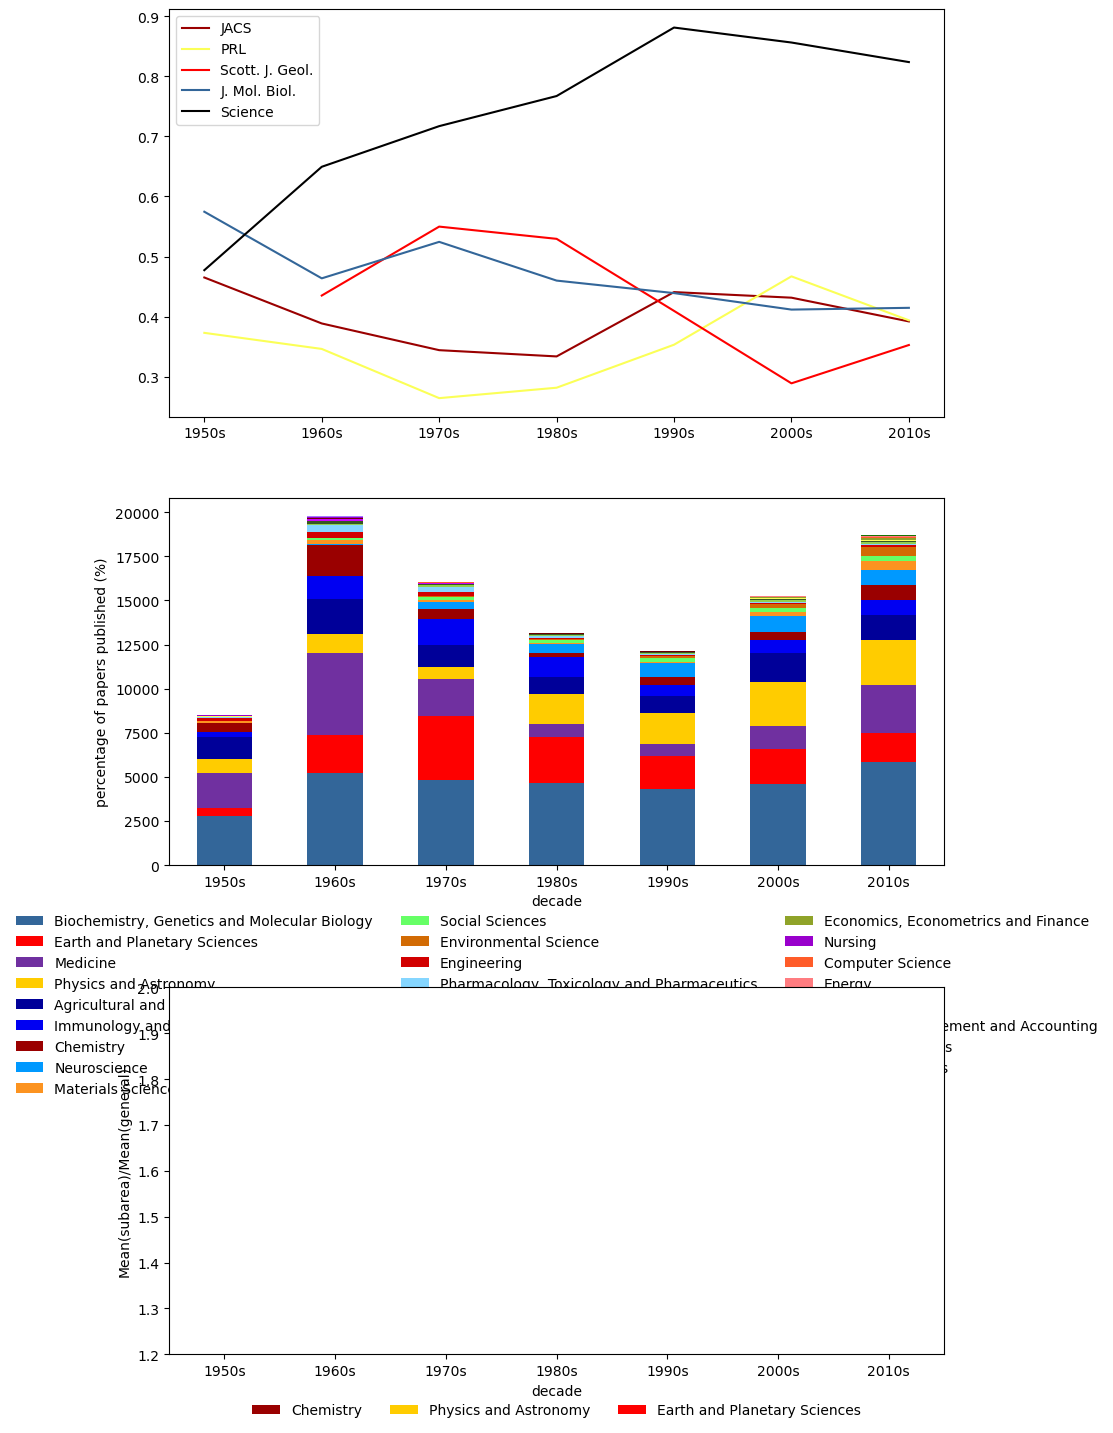

In [156]:
fig = plt.figure(figsize=(10,18))

# subplot 1
plt.subplot(3,1,1)
jnl_color_dict = {
    'Science': '#000000',
    'J. Mol. Biol.': '#336699',
    'PRL': '#FBFF57',
    'Scott. J. Geol.': '#FE0000',
    'JACS': '#9A0000'
}
jnl_model.disc2abbr = {
    'Science': 'Science',
    'Journal of Molecular Biology': 'J. Mol. Biol.',
    'Physical Review Letters': 'PRL',
    'Scottish Journal of Geology': 'Scott. J. Geol.',
    'Journal of the American Chemical Society': 'JACS'
}
jnl_cs_df.rename(columns=jnl_model.disc2abbr, inplace=True)
sns.lineplot(jnl_cs_df, palette=jnl_color_dict, dashes=False)

# subplot 2
plt.subplot(3,1,2)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

# subplot 3
plt.subplot(3,1,3)
ax_cs = cs_df[['Chemistry',
               'Physics and Astronomy', 
               'Earth and Planetary Sciences']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.2, 2.0)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [159]:
fig.savefig('Nature.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False)

# Science

In [30]:
count_df = count_paper_num_for_disc(3880285)

2024-11-08 10:21:41 -- start searching in 1950 to 1959
2024-11-08 10:21:41 -- start loading 'paper_df'...
2024-11-08 10:21:41 -- finish.
2024-11-08 10:21:41 -- start loading 'ref_df'...
2024-11-08 10:21:41 -- finish.
2024-11-08 10:21:41 -- start loading VID_labeled...
2024-11-08 10:21:41 -- finish.
2024-11-08 10:21:42 -- start searching in 1960 to 1969
2024-11-08 10:21:42 -- start loading 'paper_df'...
2024-11-08 10:21:42 -- finish.
2024-11-08 10:21:42 -- start loading 'ref_df'...
2024-11-08 10:21:42 -- finish.
2024-11-08 10:21:42 -- start loading VID_labeled...
2024-11-08 10:21:42 -- finish.
2024-11-08 10:21:43 -- start searching in 1970 to 1979
2024-11-08 10:21:43 -- start loading 'paper_df'...
2024-11-08 10:21:43 -- finish.
2024-11-08 10:21:43 -- start loading 'ref_df'...
2024-11-08 10:21:43 -- finish.
2024-11-08 10:21:43 -- start loading VID_labeled...
2024-11-08 10:21:43 -- finish.
2024-11-08 10:21:44 -- start searching in 1980 to 1989
2024-11-08 10:21:44 -- start loading 'paper_d

In [31]:
cs_df = cal_disc_avg_cs(3880285)

2024-11-08 10:22:22 -- start loading word vectors...
2024-11-08 10:22:22 -- word vectors loaded, and its shape is: (1645, 100)
2024-11-08 10:22:22 -- start loading VID_labeled...
2024-11-08 10:22:22 -- finish.
2024-11-08 10:22:22 -- start loading word vectors...
2024-11-08 10:22:22 -- word vectors loaded, and its shape is: (3116, 100)
2024-11-08 10:22:22 -- start loading VID_labeled...
2024-11-08 10:22:22 -- finish.
2024-11-08 10:22:22 -- start loading word vectors...
2024-11-08 10:22:22 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 10:22:22 -- start loading VID_labeled...
2024-11-08 10:22:22 -- finish.
2024-11-08 10:22:22 -- start loading word vectors...
2024-11-08 10:22:22 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 10:22:22 -- start loading VID_labeled...
2024-11-08 10:22:22 -- finish.
2024-11-08 10:22:22 -- start loading word vectors...
2024-11-08 10:22:22 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 10:22:22 -- start loa

Pearson correlation coefficient: 0.569
P-value: 5.434e-17


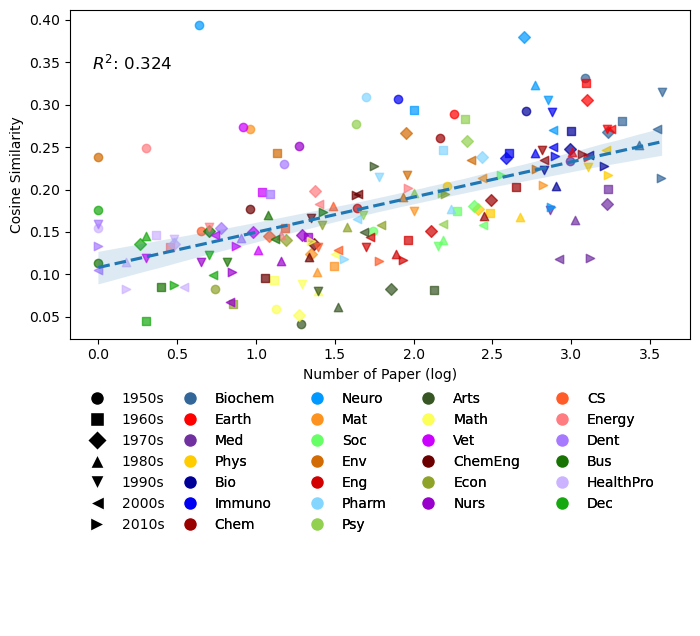

In [32]:
from scipy.stats import pearsonr

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0)

decades = count_df.index.tolist() # get decades

fig = plt.figure(figsize=(8, 8))
##########################################
ax = fig.add_subplot(2,1,1)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, color=model.discipline2color[discipline], label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

ss_res = np.sum((combined_y_vals - np.polyval(np.polyfit(combined_x_vals, combined_y_vals, 1), combined_x_vals)) ** 2)
ss_tot = np.sum((combined_y_vals - np.mean(combined_y_vals)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
ax.text(0.035, 0.87, f"$R^2$: {r_squared:.3f}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',)

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
print(f"Pearson correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3e}")

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model.disc2abbr[disc],
                                 markerfacecolor=model.discipline2color[disc], markersize=10)
                      for disc in disciplines]

legend_ax = fig.add_subplot(2,1,2)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(0.0, 0.75), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                              loc="upper left", bbox_to_anchor=(0.15, 0.75), ncol=4, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_ylabel('Cosine Similarity')

plt.subplots_adjust(wspace=0.12, hspace=-0.125)
plt.show()

In [33]:
fig.savefig('Science_correlation.pdf', 
            facecolor='white', 
            transparent=False,
            bbox_inches='tight')

## Old layout

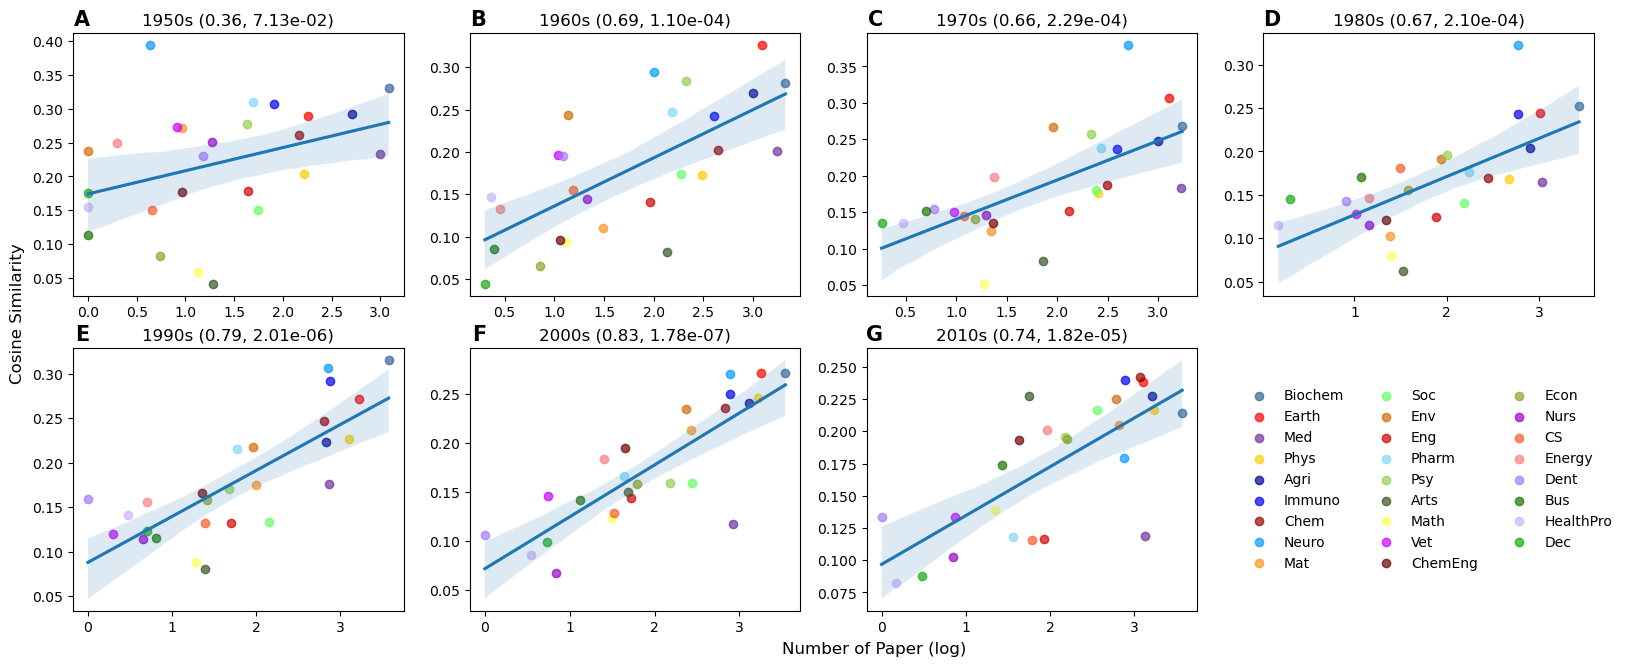

In [7]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 2x4 的 GridSpec 布局（2 行 4 列）
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(2, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFG")
center_venue = 'Science'

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, color=model.discipline2color[discipline], alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-1])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, [model.disc2abbr[label] for label in labels], loc='center', ncol=3, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.075, wspace=0.1, hspace=0.2)

plt.show()

## Archive (Science)

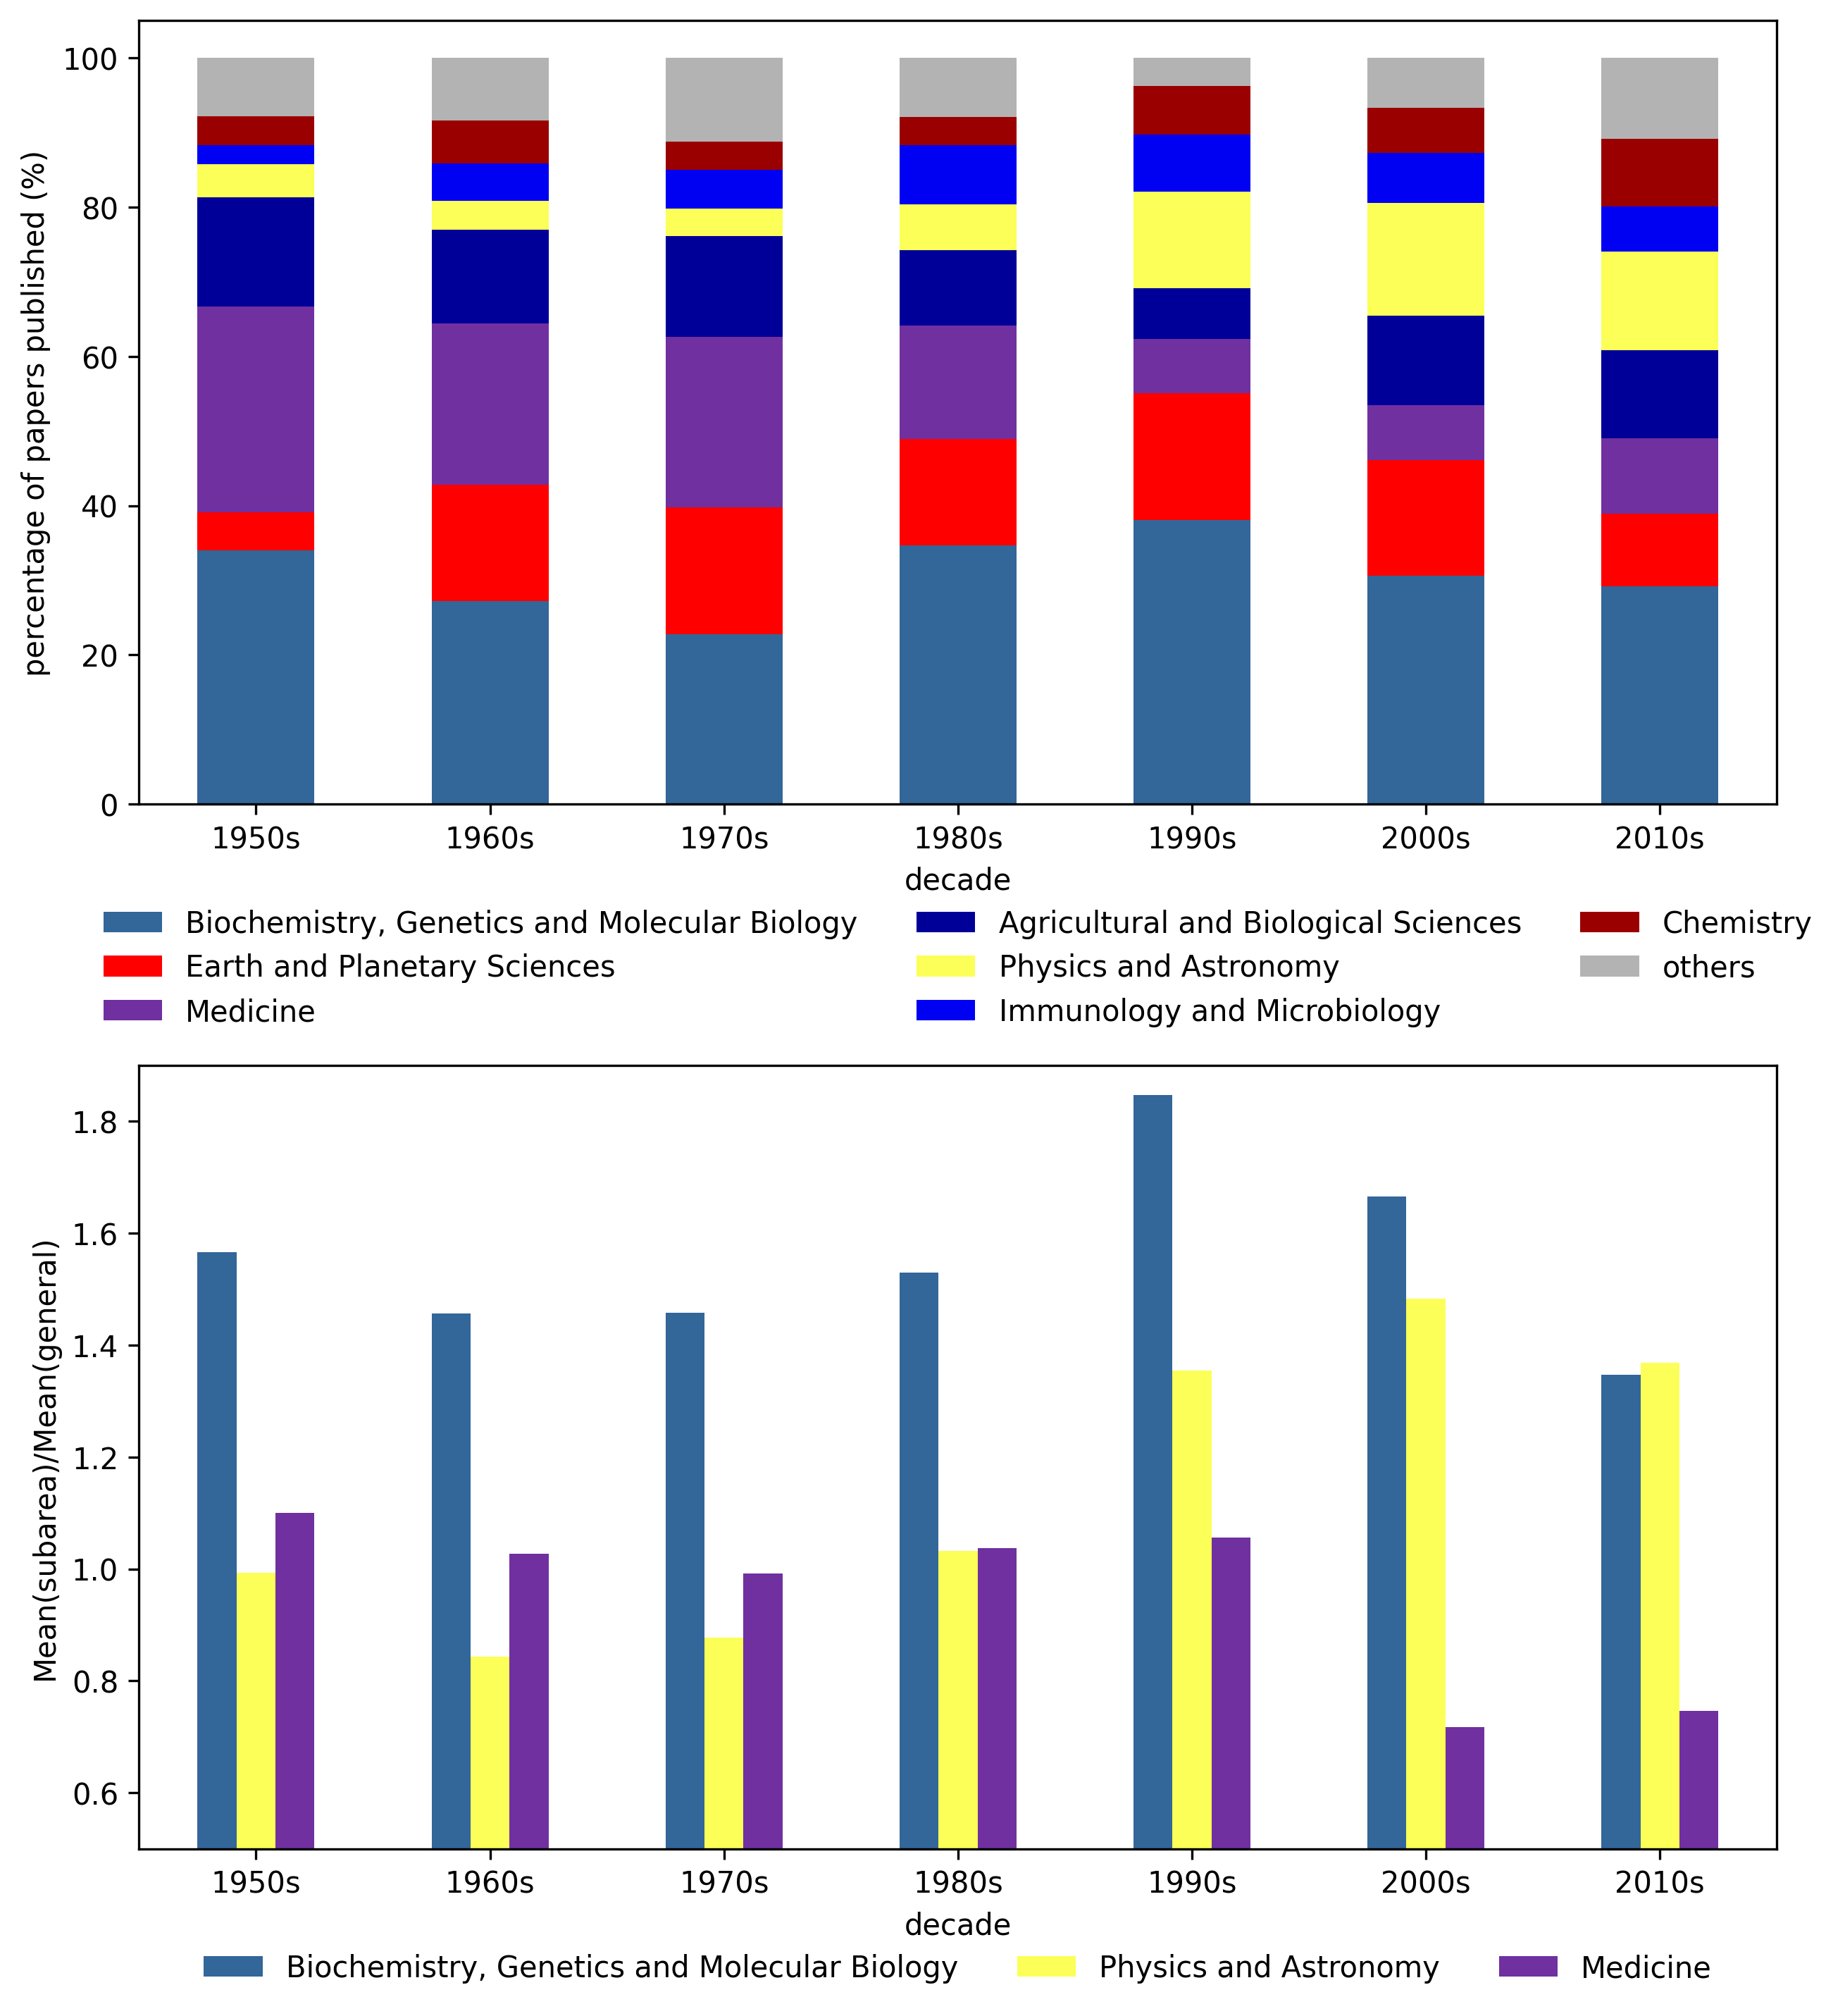

In [26]:
fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Biochemistry, Genetics and Molecular Biology',
               'Physics and Astronomy', 
               'Medicine']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(0.5, 1.9)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [27]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/Science.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# PNAS

In [34]:
count_df = count_paper_num_for_disc(125754415)

2024-11-08 10:22:32 -- start searching in 1950 to 1959
2024-11-08 10:22:32 -- start loading 'paper_df'...
2024-11-08 10:22:32 -- finish.
2024-11-08 10:22:32 -- start loading 'ref_df'...
2024-11-08 10:22:32 -- finish.
2024-11-08 10:22:32 -- start loading VID_labeled...
2024-11-08 10:22:32 -- finish.
2024-11-08 10:22:33 -- start searching in 1960 to 1969
2024-11-08 10:22:33 -- start loading 'paper_df'...
2024-11-08 10:22:33 -- finish.
2024-11-08 10:22:33 -- start loading 'ref_df'...
2024-11-08 10:22:33 -- finish.
2024-11-08 10:22:33 -- start loading VID_labeled...
2024-11-08 10:22:33 -- finish.
2024-11-08 10:22:33 -- start searching in 1970 to 1979
2024-11-08 10:22:33 -- start loading 'paper_df'...
2024-11-08 10:22:33 -- finish.
2024-11-08 10:22:33 -- start loading 'ref_df'...
2024-11-08 10:22:33 -- finish.
2024-11-08 10:22:33 -- start loading VID_labeled...
2024-11-08 10:22:33 -- finish.
2024-11-08 10:22:34 -- start searching in 1980 to 1989
2024-11-08 10:22:34 -- start loading 'paper_d

In [35]:
cs_df = cal_disc_avg_cs(125754415)

2024-11-08 10:25:24 -- start loading word vectors...
2024-11-08 10:25:24 -- word vectors loaded, and its shape is: (1645, 100)
2024-11-08 10:25:24 -- start loading VID_labeled...
2024-11-08 10:25:24 -- finish.
2024-11-08 10:25:24 -- start loading word vectors...
2024-11-08 10:25:24 -- word vectors loaded, and its shape is: (3116, 100)
2024-11-08 10:25:24 -- start loading VID_labeled...
2024-11-08 10:25:24 -- finish.
2024-11-08 10:25:24 -- start loading word vectors...
2024-11-08 10:25:24 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 10:25:24 -- start loading VID_labeled...
2024-11-08 10:25:24 -- finish.
2024-11-08 10:25:24 -- start loading word vectors...
2024-11-08 10:25:24 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 10:25:24 -- start loading VID_labeled...
2024-11-08 10:25:24 -- finish.
2024-11-08 10:25:24 -- start loading word vectors...
2024-11-08 10:25:24 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 10:25:24 -- start loa

Pearson correlation coefficient: 0.581
P-value: 7.771e-18


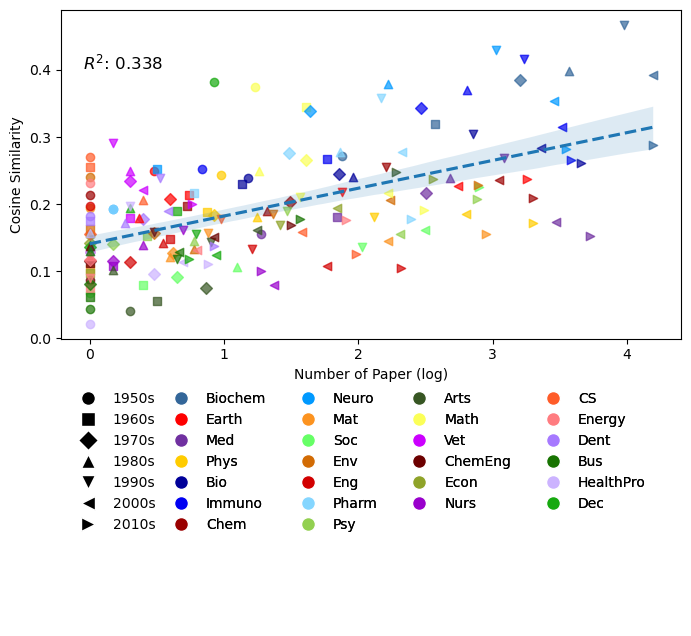

In [36]:
from scipy.stats import pearsonr

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0)

decades = count_df.index.tolist() # get decades

fig = plt.figure(figsize=(8, 8))
##########################################
ax = fig.add_subplot(2,1,1)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, color=model.discipline2color[discipline], label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

ss_res = np.sum((combined_y_vals - np.polyval(np.polyfit(combined_x_vals, combined_y_vals, 1), combined_x_vals)) ** 2)
ss_tot = np.sum((combined_y_vals - np.mean(combined_y_vals)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
ax.text(0.035, 0.87, f"$R^2$: {r_squared:.3f}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',)

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
print(f"Pearson correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3e}")

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model.disc2abbr[disc],
                                 markerfacecolor=model.discipline2color[disc], markersize=10)
                      for disc in disciplines]

legend_ax = fig.add_subplot(2,1,2)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(0.0, 0.75), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                              loc="upper left", bbox_to_anchor=(0.15, 0.75), ncol=4, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_ylabel('Cosine Similarity')

plt.subplots_adjust(wspace=0.12, hspace=-0.125)
plt.show()

In [37]:
fig.savefig('PNAS_correlation.pdf', 
            facecolor='white', 
            transparent=False,
            bbox_inches='tight')

## Old layout

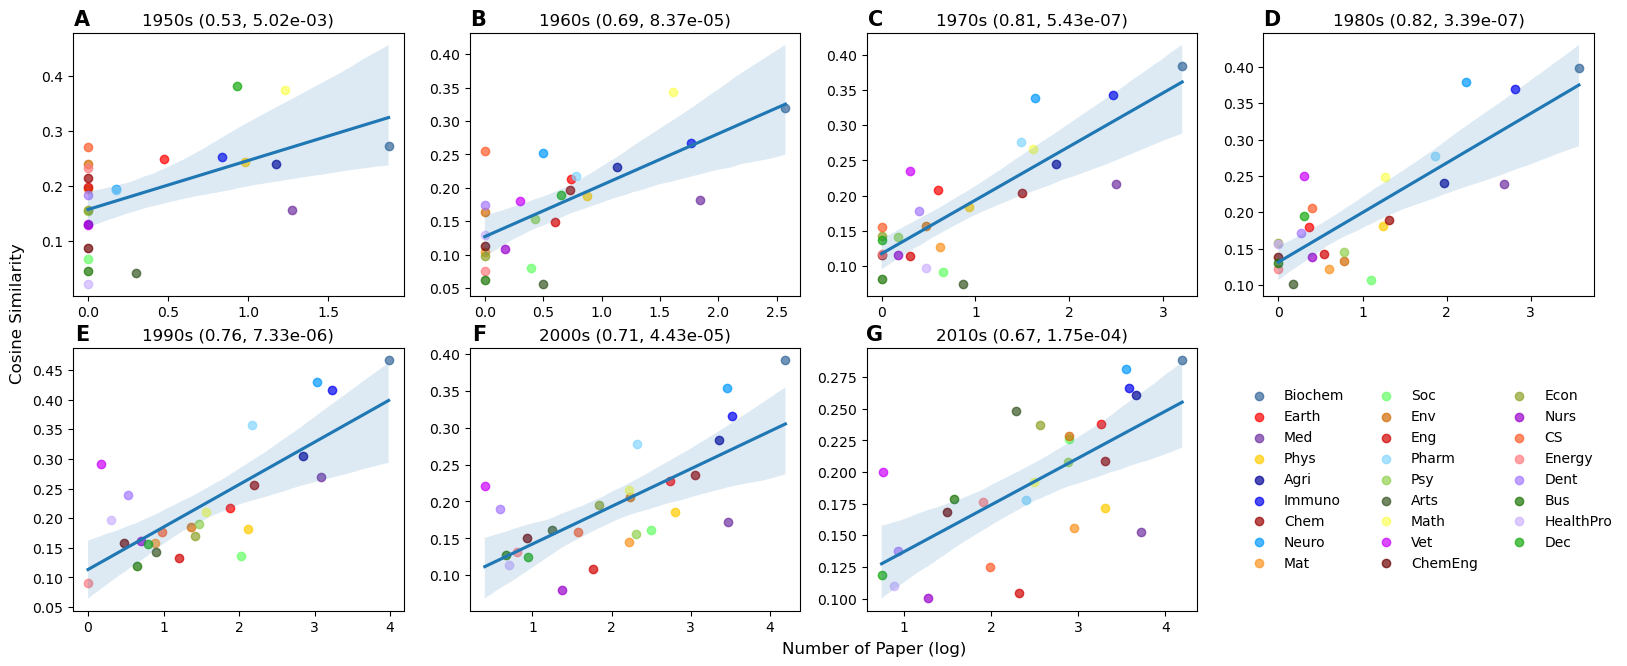

In [11]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

disciplines = list(model.disc2abbr.keys())
disciplines.remove('Multidisciplinary')

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 2x4 的 GridSpec 布局（2 行 4 列）
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(2, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFG")
center_venue = 'PNAS'

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, color=model.discipline2color[discipline], alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-1])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, [model.disc2abbr[label] for label in labels], loc='center', ncol=3, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.075, wspace=0.1, hspace=0.2)

plt.show()

## Archive (PNAS)

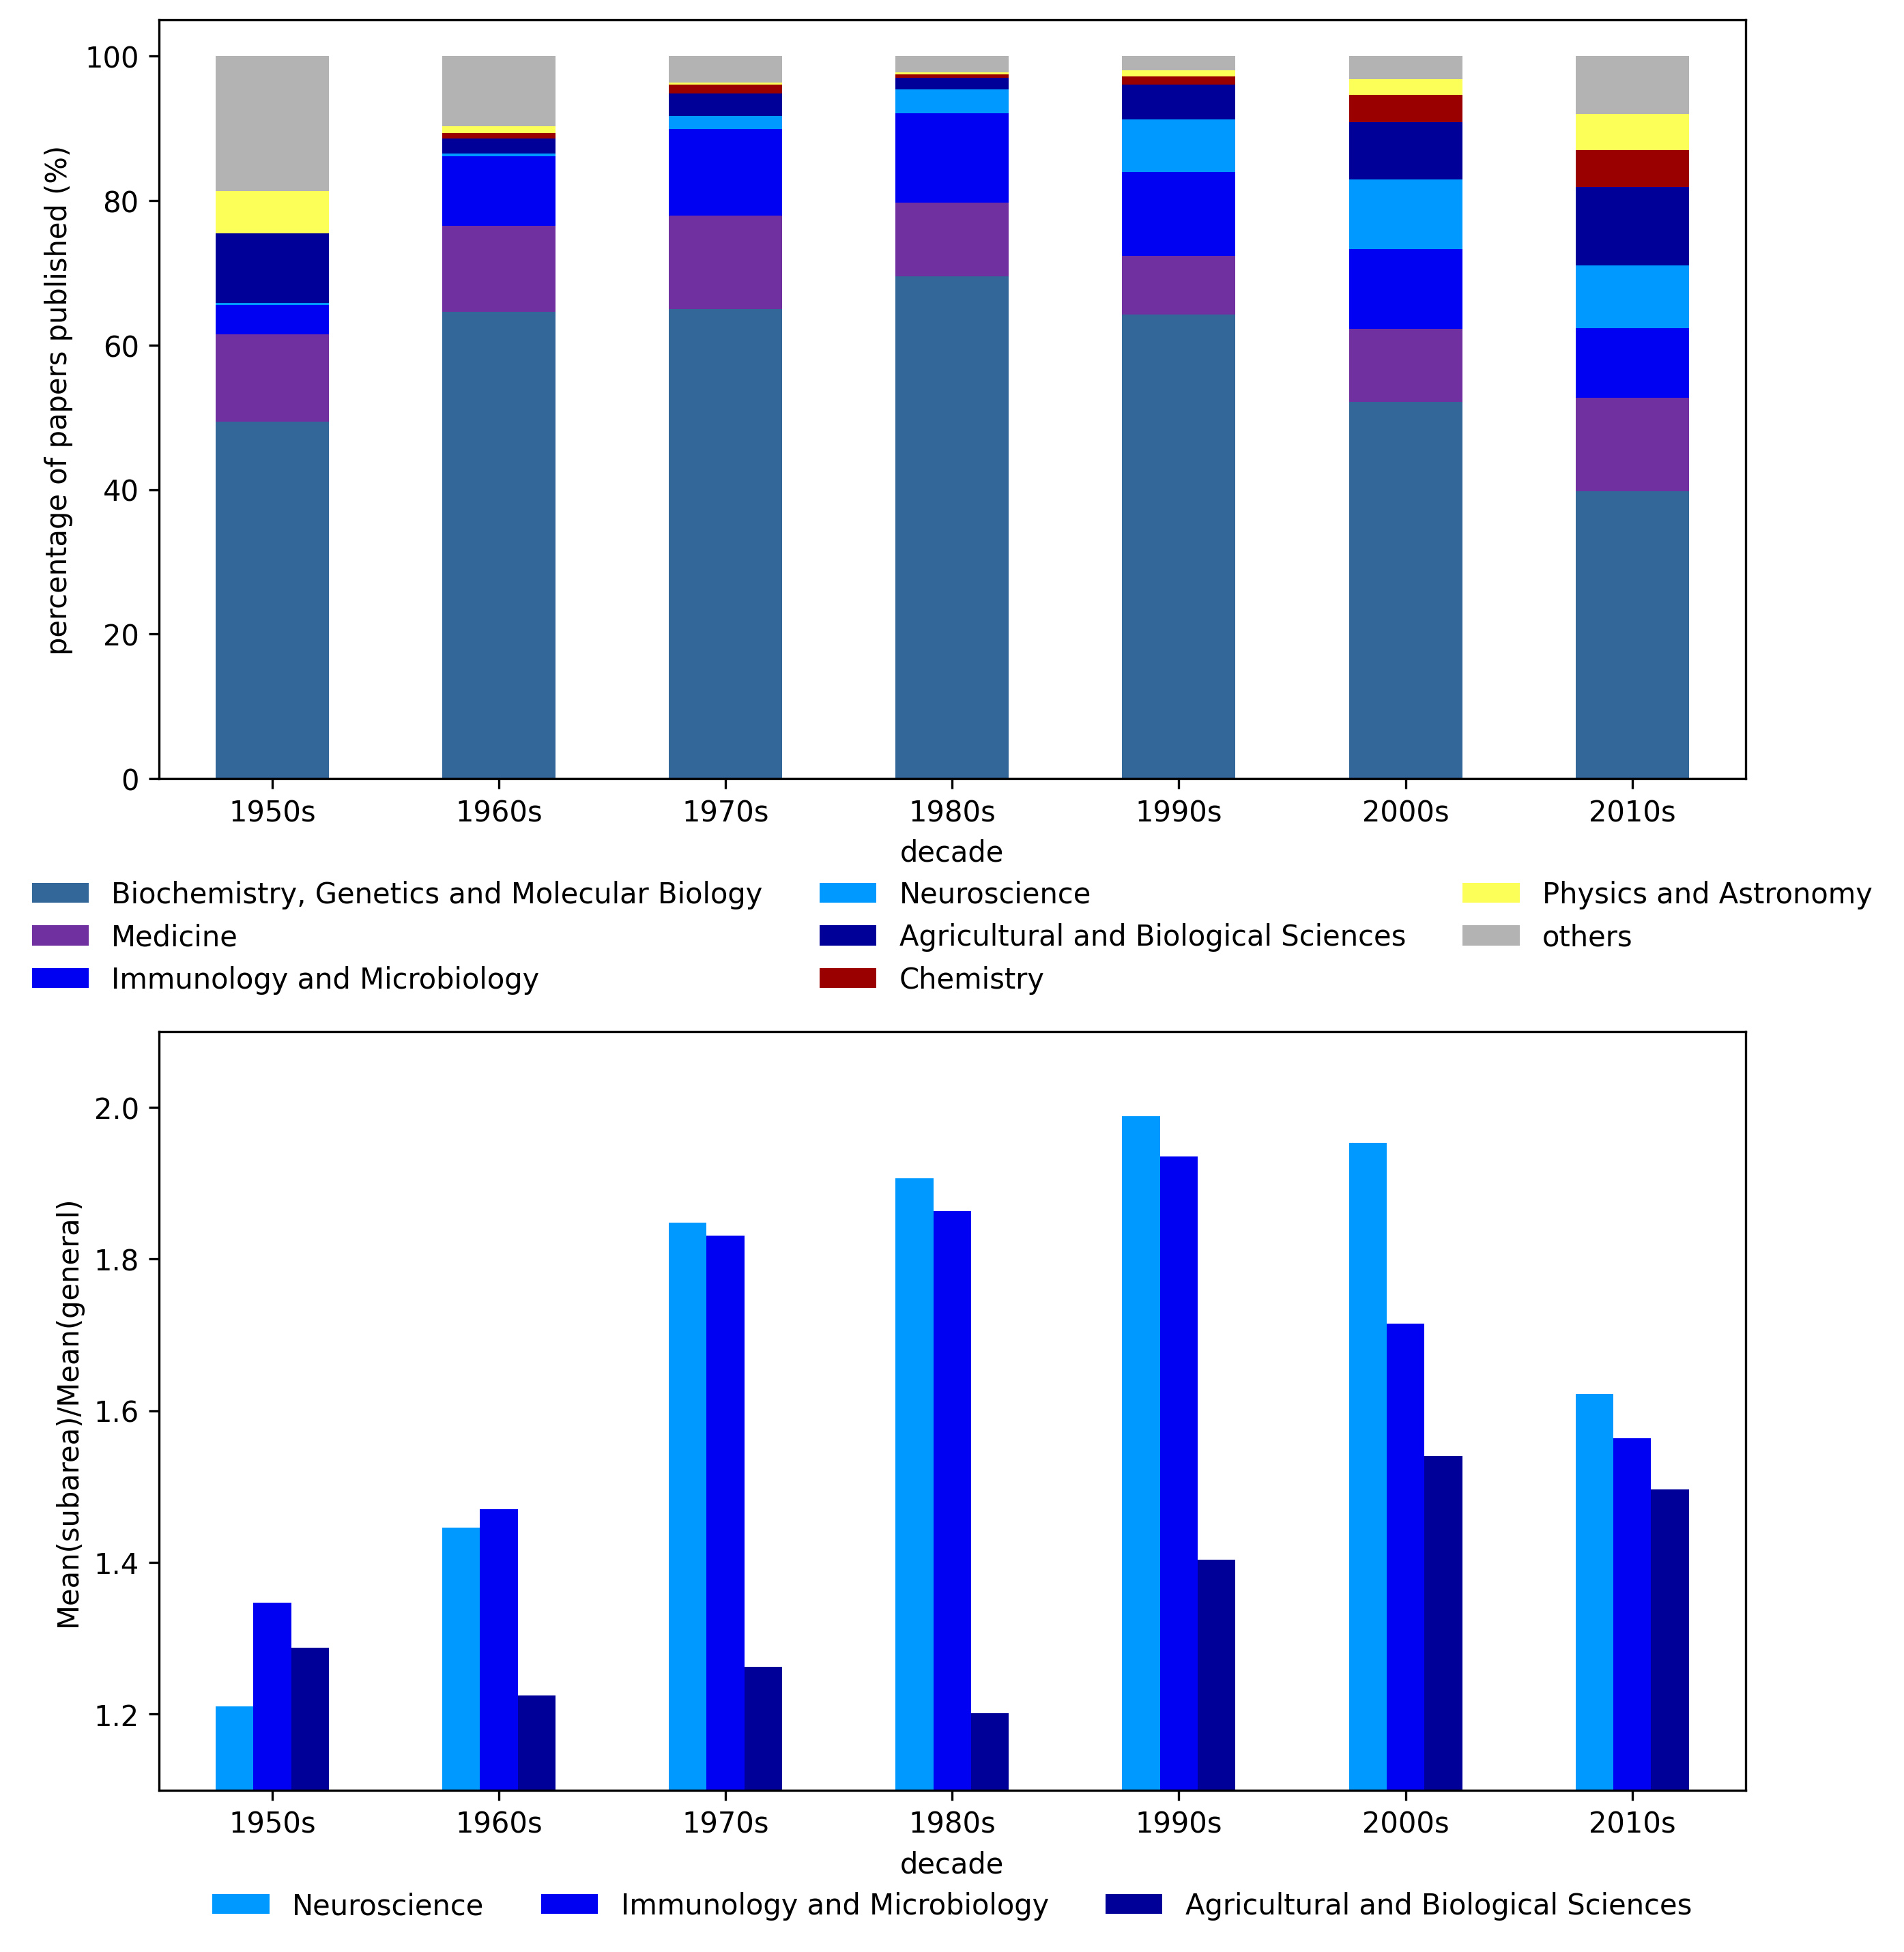

In [33]:
fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Neuroscience',
               'Immunology and Microbiology', 
               'Agricultural and Biological Sciences']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.1, 2.1)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [34]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/PNAS.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')